## <span style="color:blue">Lavey results -- in draft -- </span>

### <span style="color:#008891">Methods</span>
1. data collection
2. scope

### <span style="color:#008891">Summary data</span>
#### <span style="color:#008891">All surveys</span>

1. all data
2. project lakes

### <span style="color:#008891">Code groups</span>

1. summary data
2. components
3. survey results
4. monthly median and change
5. key values by lake

#### <span style="color:#008891">Code groups: Significant events</span>

1. definition
2. significant events per lake
3. frequency of ocurrence per group and lake

#### <span style="color:#008891">Regional assessment tools</span>

Find the locations on one lake that may be hotspots for litter accumulation. Identify the ones that may be interesting to monitor in the future. Use the provided graphic and map to make your decision.
    
    

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]


def make_ecdf(somdata, numsamps):
    vals = somdata.pcs_m.sort_values()
    valsy = [i/numsamps for i in np.arange(numsamps)]
    return vals, valsy


def assign_a_level(x, a_list, labels):
    if x in a_list:
        this_level = labels[0]
    else:
        this_level = labels[1]
    return this_level


# convenience functions for tables
def make_table_grids(anax):
    anax.grid(False)
    anax.spines["top"].set_visible(False)
    anax.spines["right"].set_visible(False)
    anax.spines["bottom"].set_visible(False)
    anax.spines["left"].set_visible(False)
    return(anax)

def table_fonts(a_table, size=12):
    a_table.auto_set_font_size(False)
    a_table.set_fontsize(size)
# variables/arrays that are frequently used:
# project lakes

the_lakes = [
    "Bielersee",
    "Walensee",
    "Lac Léman",
    "Zurichsee",
    "Neuenburgersee",
    "Thunersee",
    "Lago Maggiore",
    "Brienzersee",
]

# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...
# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}
label45r = {'rotation':45, 'ha':'right'}
label45c = {'rotation':45, 'ha':'center'}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# the code group definitions
som_names = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}
def make_group_map(a_dict_of_lists):
    wiw = {}
    for group in a_dict_of_lists:
        keys = a_dict_of_lists[group]
        a_dict = {x:group for x in keys}
        wiw.update(**a_dict)
    return wiw

these_groups ={k:ut.json_file_get(F"{output}/code_groups/{v}") for k,v in som_names.items()}
these_groups.update({"fragmented plastics":["G79", "G78", "G75"]})
group_names = list(these_groups.keys())

# collect the codes
accounted = [v for k,v in these_groups.items()]
accounted = [item for a_list in accounted for item in a_list]

In [3]:
# the local file structure. The resources are located in the corresponding directory.


# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False

french_names = {
    "waste water":"traitement d'eau",
    "less than 5mm":"moins que 5mm",
    "construction":"construction",
    "food":"alimentation",
    "agg-con-trans": "agg-con-trans",
    "agriculture":"agriculture",
    "the rest":"le rest",
    "tobacco":"tabac",
    "recreation": "recreation",
    "fragmented plastics":"plastiques fragmentés",
    "packaging":"emballages",
    "personal items":"affaires personnelles",
    "survey total":"total du jour"
}



# collect the names:
group_names = list(these_groups.keys())

# choose a lake:
lake = 'Lac Léman'
coi = 'Lavey-Morcles'
bassin_label = 'Rhône-Léman'
bassin = ['Lac Léman', 'Rhône']
lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'laveysummary'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg['date'] = pd.to_datetime(dfAgg['date'])
dfAgg = dfAgg[dfAgg.date >= start_date]
# dfAgg = dfAgg[dfAgg.location != 'pfafikon-bad']
dfAgg['groupname'] = 'nogroup'

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])
dfSurveys = dfSurveys[dfSurveys.date >= start_date]
# dfSurveys = dfSurveys[dfSurveys.location != 'pfafikon-bad']
dfSurveys['groupname'] = 'nogroup'

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

cols_to_keep = ['loc_date',
                'location',
                'water_name',
                'date',
                'population',
               ]

# geo data: explantory variables, index by slug and make a map:
# dfStreets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000.csv", index_col='slug')['length']
# dfBlds = pd.read_csv(F"{geo_data}/exp_variables/builds_500.csv", index_col='slug')['surface']
# dfRivs = pd.read_csv(F"{geo_data}/exp_variables/riparian_intersects.csv", index_col='slug')['NUMPOINTS']

# restrict to lakes only
# aggregated to the parent code, which is an MLW code
dfS = dfAgg.copy()
dfS['loc_date'] = zip(dfS.location,dfS.date)

# these values are not aggregated:
dfNag = dfSurveys.copy()
thesecols = ['loc_date',
             'location',
             'water_name',
             'date']

# there are somecodes that allways need to be aggregated:
dfNagl = dfNag.copy()
mapG82 = dfNagl[dfNagl.code.isin(['G82', 'G912'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG82['code'] = 'G82'
mapG81 = dfNagl[dfNagl.code.isin(['G81', 'G911'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG81['code'] = 'G81'
mapG74 = dfNagl[dfNagl.code.isin(['G74', 'G910', 'G909'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG74['code'] = 'G74'
dfnofoam = dfNag.loc[~dfNag.code.isin(['G82', 'G912','G81', 'G911','G74', 'G910', 'G909'])]
newdf = pd.concat([dfnofoam,mapG74,mapG81,mapG82])
newdfx = newdf.copy()

dfS['population']=dfS.location.map(lambda x: dfBeaches.loc[x]['population'])
dfS['loc_date'] = list(zip(dfS.location, dfS.date))

# these need to be moved to context:
# map geo values to aggregated survey results:
# dfS['streets'] = dfS.location.map(lambda x: dfStreets.loc[x])
# dfS['buildings'] = dfS.location.map(lambda x: dfBlds.loc[x])
# dfS['rivs'] = dfS.location.map(lambda x: dfRivs.loc[x])
# dfS['pop_streets'] = dfS.population + dfS.streets
# dfS['pop_builds'] = dfS.population + dfS.buildings
# dfS['streets_builds'] = dfS.streets + dfS.rivs

newdf['population']=newdf.location.map(lambda x: dfBeaches.loc[x]['population'])
newdf['loc_date'] = list(zip(newdf.location, newdf.date))

# these need to be moved to context
# map geo values to non aggregated survey results:
# newdf['streets'] = newdf.location.map(lambda x: dfStreets.loc[x])
# newdf['buildings'] = newdf.location.map(lambda x: dfBlds.loc[x])
# newdf['rivs'] = newdf.location.map(lambda x: dfRivs.loc[x])
# newdf['pop_streets'] = newdf.population + newdf.streets
# newdf['pop_builds'] = newdf.population + newdf.buildings
# newdf['streets_builds'] = newdf.streets + newdf.buildings

if aggregated:
    print("Using aggregated data")
    useThis = dfS.copy()
else:
    print("Using non aggregated data")
    useThis = newdf.copy()
    
codes_in_use = useThis.code.unique()
locations_in_use = useThis.location.unique()
# make a code group of the unaccounted for codes:
the_rest = [x for x in codes_in_use if x not in accounted]
these_groups.update({'the rest':the_rest})
group_names = list(these_groups.keys())

# get a list of all the locations within the designatedcatchment area
som_beaches = dfBeaches[dfBeaches.water_name.isin(bassin)].copy()

# some locations will not have data for the time frame, filter those out
not_these_beaches = list(set(som_beaches.index)-set(locations_in_use))
these_beaches = som_beaches.loc[~som_beaches.index.isin(not_these_beaches)].copy()

# list of locations in the catchment area with data for the date range
bassin_locs = these_beaches.index

# map code to group in the survey results
a_group_map = make_group_map(these_groups)
useThis['groupname'] = useThis.code.map(lambda x: a_group_map[x])

# make sure to have acces to this column throughout
cols_to_keep.append('groupname')

# keep track of the files you are exporting:
files_generated = []

# method to save
def add_output(a_name, a_tag, atype="table", fignum=0, a_list=files_generated):
    tableonefile = F"{project_directory}/{a_name}"
    files_generated.append({'tag':a_tag, 'number':fignum, 'file':tableonefile,'type':atype})
    plt.savefig(tableonefile, dpi=300)

# save files
survey_csv = F"{project_directory}/survey_data.csv"
files_generated.append(survey_csv)
useThis.to_csv(survey_csv, index=False)

beaches_csv = F"{project_directory}/beach_data.csv"
files_generated.append(beaches_csv)
these_beaches.to_csv(beaches_csv, index=False)

Using non aggregated data


In [4]:
fr_defs_codes = {
    'G95': 'Coton-tige',
    'G100': 'Médical conteneurs/tubes/ emballages',
    'G98': 'Couches - lingettes',
    'G96': 'Serviettes hygiéniques / protège-slips / tampons et ...',
    'G91': 'Porte-biomasse',
    'G133':'Préservatifs, y compris emballage',
    'G144':'Tampons',
    'G97': 'Rafraîchisseurs de toilettes',
    "G112":"Pellets industriels (GPI)",
    "G117":"polystyrène < 5mm",
    "G106":"Fragments de plastique angulaires <5mm",
    "G103":"fragments de plastique arrondis <5mm",
    "G115":"Mousse de plastique <5mm",
    "G105":"fragments de plastique subangulaires <5mm",
    "G114":"Films <5mm",
    "G118":"Petites sphères industrielles <5mm",
    "G123":"Granulés de polyuréthane < 5mm",
    "G113":"Filaments <5mm",
    "G119":"Plastique utilisateur en feuille (>1mm)",
    "G122":"Fragments de plastique ( >1mm)",
    "G107":"Boulettes cylindriques < 5mm",
    "G108":"pastilles de disque <5mm",
    "G109":"Pellets plats <5mm",
    "G111":"Granulés sphéroïdes < 5mm",
    "G104":"fragments de plastique sous-arrondis <5mm",
    "G81":"Morceaux de polystyrène expansé 0,5cm - 2,5cm",
    "G82":"Mousse de polystyrène ; perles/billes expansées 2,5 cm",
    "G74":"Mousse de plastique pour l'isolation thermique ou ...",
    "G89":"Déchets de construction en plastique",
    "G73":"Articles et pièces en mousse (sans emballage ou... liés)",
    "G22":"Couvercles pour produits chimiques, détergents (non alimentaires)",
    "G66":"sangles/bandes ; fermeture de paquet en plastique dur",
    "G921":"Carreaux et pièces de céramique",
    "G908": "Ruban ; électrique, isolant",
    "G186":"Débris industriels",
    "G93": "Colson, zip-ties",
    "G87": "Ruban adhésif, masquage/conduit/emballage",
    "G194":"Câbles, fil(s) métallique(s) souvent à l'intérieur du caoutchouc ou...",
    "G931":"Ruban adhésif pour barrière, police, construction",
    "G68":"Fragments de fibre de verre",
    "G83":"Pièces en polystyrène > 50cm",
    "G17":"Cartouche pour pistolet d'injection",
    "G174":"Bombes aérosols",
    "G190":"Bidons de peinture",
    "G188":"Autres bidons < 4 L",
    "G27": "Mégots et filtres à cigarettes", 
    "G30": "Emballages alimentaires ; emballages de bonbons, de snacks", 
    "G21": "Couvercles de bouteilles", 
    "G25": "Tabac ; emballages en plastique, conteneurs", 
    "G24" :"Couvercle/anneaux de fermeture de bouteilles/récipients en plastique", 
    "G35": "Pailles et agitateurs", 
    "G31": "Bâtonnets de sucette", 
    "G32": "Jouets et faveurs de fête", 
    "G33": "Gobelets, couvercles, mousse à usage unique et plastique dur", 
    "G34": "Couverts, assiettes et plateaux palstique",
    "G67":"bâche plastique, épaisse, couvrant, enveloppant,",
    "G38":"Couvertures ; emballages en plastique gros calibre",
    "G204" :"Matériaux de construction ; briques, tuyaux, ciment",
    "G191" :"Fils et grillages",
    "G170" :"Bois (transformé)",
    "G161" :"Bois transformé",
    "G919" :"Clous, vis, boulons, etc.",
    "G171" :"Autre bois < 50cm",
    "G13":"Bouteilles, conteneurs, fûts pour le transport, le stockage",
    "G14": "Bouteilles d'huile moteur",
    "G172":"Autres bois > 50cm",
    "G41":"Gant industriel/professionnel",
    "G936":"Film sur les serres",
    "G937":"Appâts à phéromones pour les vignobles",
    "G943":"Clôturer l'agriculture, plastique",
    "G36":"Sacs/sacs en plastique résistant pour 25 kg ou plus",
    "G81":"Morceaux de polystyrène expansé 0,5cm - 2,5cm",
    "G30":"Emballages alimentaires ; emballages de bonbons, de snacks",
    "G82":"Mousse de polystyrène; perles/billes expansées > 2,5 cm -",
    "G74":"Mousse de plastique pour l'isolation thermique ou ...",
    "G117": "Polystyrène expansée < 5mm",
    "G89":"Déchets de construction en plastique",
    "G21":"Couvercles de boissons",
    "G24":"Couvercle/anneaux de fermeture de bouteilles/récipients en plastique",
    "G23":"Couvercles non identifiés",
    "G73":"Articles et pièces en mousse (sans emballage ou... liés)",
    "G22":"Couvercles pour produits chimiques, détergents (non alimentaires)",
    "G78":"Plastiques fragmentés .5mm < x < 25mm",
    "G79":"Plastiques fragmentés x > 25mm",
    "G200":"verre brisé ",
    "G10":"Emballage fast food",
    "G3":"sacs en plastique, épiceries, achats",
    "G137":"Vêtements, serviettes, chiffons",
    "G175":"canettes de boissons",
    "G199":"Pièces métalliques",
    'G64':'Aile de véhicule',
    'G135':"vêtements, chaussures, gants",
    'G8': "Bouteilles en PET de plus d'un demi-litre",
    'G941':"Emballages en plastique, pas pour les aliments",
    'G198':"Pièces métalliques de moins de 50 cm",
    'G48':"Corde synthétique",
    'G2':'sacs',
    'G37':"sac en filet",
    'G134':"Objets en caoutchouc",
    'G136':"Chaussures",
    'G176':"Des boîtes de conserve" ,
    'G7':"Bouteilles en PET moins que d'un demi-litre",
    'G40':"Gants pour le jardinage",
    'G927':"la corde de désherbage",
    'G65':"Seaux",
    'G101':"Sac à excréments de chien",
    'G19':"Pièces détachées:pour voitures",
    'G129':"chambres à air et feuilles de caoutchouc",
    'G4':"Sacs de congélation en plastique",
    'G90': "pots de fleurs en plastique",
    'G211': "articles médicaux : pansements, attelles",
    'G933':"boîtier d'appareil",
    'G914':"Articles utilitaires en plastique",
    'G900':"Gants en latex: ppe",
    'G142':"Corde, non synthétique",
    'G149': "emballages en papier",
    'G76':"polystyrène expansé non isolant",
    'G70':"cartouche de fusil de chasse" ,
    'G195': "piles ménage",
    'G185':"récipient en métal"
}

In [5]:
def map_to_group_type(x):
    if x in ['diffusion','less than 5mm']:
        thistype = 'phys'
    else:
        thistype = 'econ'
    return thistype
limit=50
def count_k(a_string, limit):
    split = a_string.split(" ")
    total = 0
    new_words = []
    for i,word in enumerate(split):
        if (total + len(word))+1 >= limit:
            thisnewword = F"{split[i-1]}..."
            if (len(thisnewword) + total) <= limit:
                del new_words[-1]
                new_words.append(thisnewword)
            else:
                continue
        else:
            total += len(word)+1
            new_words.append(word)

    return " ".join(new_words)

colors = ['dodgerblue', 'salmon', 'teal', 'red','maroon','goldenrod', 'mediumspringgreen', 'slategray','olive','yellowgreen', 'purple', 'orange', 'cyan']
grouppalette = {x:colors[i] for i,x in enumerate(group_names)}


is_french = True
is_german = False
is_italian = False

french_sum_names = {"survey total":"total de l'enquête", **french_names}
thing = 'objets'
parent = "de l'ensemble"
french_pcm = "pièces par mètre"
french_srs = "résultats des recensements"
french_pcg = "par groupe de codes"
french_pct = "pourcentage du total"
french_med = "médian"
french_mm = "médiane mensuelle"
french_change = 'changement'
french_bg = "par groupe"
french_nooutliers = "les valeurs extrêmes ne sont pas indiquées"
french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité', '% of total':'% du total', 'group':'groupe', 'national median':'médiane nationale'}

of_prep= 'de'
frname = [v for k,v in french_names.items()]
frpalette = {french_names[x]:grouppalette[x] for x in grouppalette}
summary_row_fr = ['moyenne', 'écart type', 'min', '25%', 'médianne', '75%', 'max']
french_key_values = "valeurs clés"

In [6]:
if is_french:    
    sommarkdown = """### <span style='color:#1e90ff'>Méthodes</span>\n#### <span style='color:#008891'>Source des données, calendrier, portée géographique et méthodes de collecte</span>\n
    Les données utilisées pour cette analyse sont les résultats d'enquêtes sur les déchets de plage menées en Suisse. Toutes les enquêtes qui ont été menées sur le lac de Bienne, le lac de Neuchâtel, le lac de Thoune, le lac Walensee, le lac de Zurich, le lac Léman, le lac Brienze et le lac Magiore ont été prises en compte.\n
    Les données ont été collectées selon le protocole décrit ici https://www.plagespropres.ch/. En bref, toutes les déchets visibles sont collectées le long d'une plage à une distance mesurée du bord de l'eau. La largeur de la zone d'étude dépend du terrain et du niveau de l'eau. La ligne de rive visible ou la structure physique la plus proche définit la largeur d'une enquête (figure 1).\n
    Des enquêtes ont été menées par:\n
    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?\n
    Cette analyse est un document open source. Le cahier de notes de travail est disponible dans le dépôt situé ici: https://github.com/hammerdirt-analyst/iqals.\n
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff">Methods</span>\n#### <span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>\n
    The data for this analysis is the results from beach-litter surveys conducted in Switzerland.\n
    All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered.\n 
    The data was collected according to the protocol described here https://www.plagespropres.ch/. In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey (figure 1).\n
    Surveys were conducted by the following organizations:\n
    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?\n
    This analysis is an open source document. The working note book is available in the repository located here https://github.com/hammerdirt-analyst/iqals.\n

    """

In [7]:
display(Markdown(sommarkdown))

### <span style='color:#1e90ff'>Méthodes</span>
#### <span style='color:#008891'>Source des données, calendrier, portée géographique et méthodes de collecte</span>

    Les données utilisées pour cette analyse sont les résultats d'enquêtes sur les déchets de plage menées en Suisse. Toutes les enquêtes qui ont été menées sur le lac de Bienne, le lac de Neuchâtel, le lac de Thoune, le lac Walensee, le lac de Zurich, le lac Léman, le lac Brienze et le lac Magiore ont été prises en compte.

    Les données ont été collectées selon le protocole décrit ici https://www.plagespropres.ch/. En bref, toutes les déchets visibles sont collectées le long d'une plage à une distance mesurée du bord de l'eau. La largeur de la zone d'étude dépend du terrain et du niveau de l'eau. La ligne de rive visible ou la structure physique la plus proche définit la largeur d'une enquête (figure 1).

    Des enquêtes ont été menées par:

    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?

    Cette analyse est un document open source. Le cahier de notes de travail est disponible dans le dépôt situé ici: https://github.com/hammerdirt-analyst/iqals.

    
    

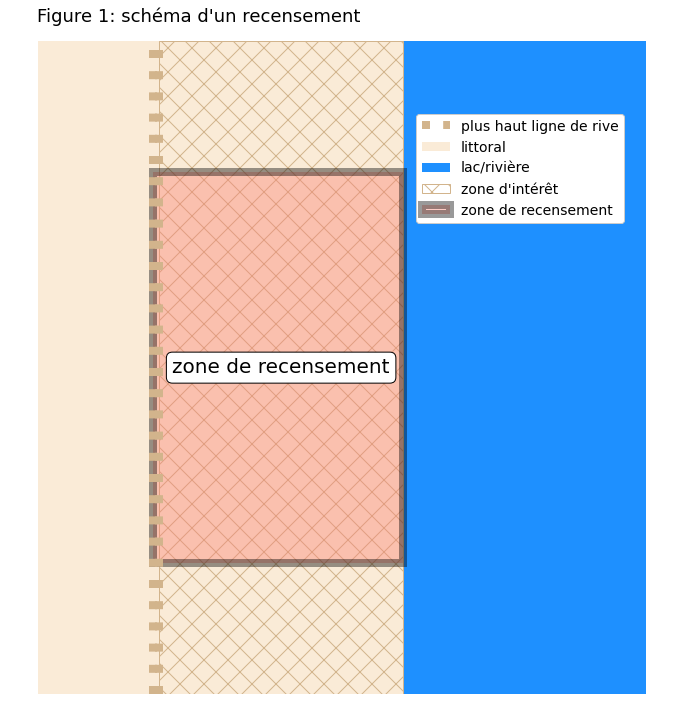

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
figure_num = 1
map_num = 1

plt.axvspan(xmin=0, xmax=1, fc='antiquewhite', label='littoral')
plt.axvspan(xmin=0.6, xmax=1, fc='dodgerblue', label='lac/rivière')
# plt.axvspan(xmin=0.2, xmax=0.5, fc='None', label='debris field')
plt.axvspan(xmin=0.2, xmax=0.6, fc='None', ec='tan', hatch="x", label="zone d'intérêt")
plt.axvspan(xmin=0.19, xmax=0.6, ymin=0.2, ymax=0.8, fc='salmon', alpha=0.4, ec='black', linewidth=8, label='zone de recensement')
plt.axvline(x=0.2, linestyle=":",  c='tan', linewidth=8, label ="plus haut ligne de rive" )
plt.axvline(x=0.19, linestyle=":",  c='tan', linewidth=8 )
ax.annotate("zone de recensement", xy=(0.4, 0.5), xycoords="data",
                  va="center", ha="center", size=20,
                  bbox=dict(boxstyle="round", fc="w"))

make_table_grids(ax)
plt.xticks([])
plt.yticks([])
plt.suptitle(F"Figure {figure_num}: schéma d'un recensement", x=0.16, fontsize=18, y=0.92,ha='left')
plt.legend(fontsize=(14), framealpha=1, bbox_to_anchor=(0.6, .9), loc='upper left')

figname = F"figure{figure_num}.jpg"
atype = "figure"
add_output(figname,  'schematic of a survey', fignum=figure_num, atype=atype)
plt.show()
plt.close()

In [9]:
# figure to draw
# fig, ax = plt.subplots(figsize=(12,12))
# figure_num = 1
# map_num = 1

# ax.axvspan(xmin=0, xmax=1, fc='white', label='littoral')
# ax.vlines(x=0.5, ymin=0, ymax=0.6, linestyle=":",  color='tan', linewidth=8, label ="plus haut ligne de rive" )
# plt.axvspan(xmin=0.6, xmax=1, fc='dodgerblue', label='lac/rivière')
# plt.axvspan(xmin=0.2, xmax=0.5, fc='None', label='debris field')
# plt.axvspan(xmin=0.2, xmax=0.6, fc='None', ec='tan', hatch="x", label="zone d'intérêt")
# plt.axvspan(xmin=0.19, xmax=0.6, ymin=0.2, ymax=0.8, fc='salmon', alpha=0.4, ec='black', linewidth=8, label='zone de recensement')
# plt.axvline(x=0.2, linestyle=":",  c='tan', linewidth=8, label ="plus haut ligne de rive" )
# plt.axvline(x=0.19, linestyle=":",  c='tan', linewidth=8 )
# ax.annotate("zone de recensement", xy=(0.4, 0.5), xycoords="data",
#                   va="center", ha="center", size=20,
#                   bbox=dict(boxstyle="round", fc="w"))

# make_table_grids(ax)
# plt.xticks([])
# plt.yticks([])
# plt.suptitle(F"Figure {figure_num}: schéma d'un recensement", x=0.16, fontsize=18, y=0.92,ha='left')
# plt.legend(fontsize=(14), framealpha=1, bbox_to_anchor=(0.6, .9), loc='upper left')

# figname = F"figure{figure_num}.jpg"
# atype = "figure"
# add_output(figname,  'schematic of a survey', fignum=figure_num, atype=atype)
# plt.show()
# plt.close()

In [10]:
if is_french:
    sommarkdown = """#### <span style="color:#008891">Scope of surveys</span>\n
    Le champ d'application des enquêtes comprend toutes les berges accessibles sur les lacs mentionnés précédemment dans les conditions suivantes:\n
    
    1. Les transports publics sont à moins d'une demi-heure de marche
    2. Le lieu est un bien public
    3. La zone d'enquête est sûre
    4. Il n'y a pas de contre-indications à la réalisation d'un recensement\n    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Scope of surveys</span>\n
    The scope of the surveys includes all accessible shoreline on the previously mentioned lakes given the following conditions:\n
    
    1. Public transport is 1/2 hour away on foot
    2. The land is open to the public
    3. The location is safe
    4. There is no reason to not do the survey\n    
    """

In [11]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Scope of surveys</span>

    Le champ d'application des enquêtes comprend toutes les berges accessibles sur les lacs mentionnés précédemment dans les conditions suivantes:

    
    1. Les transports publics sont à moins d'une demi-heure de marche
    2. Le lieu est un bien public
    3. La zone d'enquête est sûre
    4. Il n'y a pas de contre-indications à la réalisation d'un recensement
    
    

In [12]:
if is_french:
    sommarkdown = F"""### <span style="color:#1e90ff"> Données de synthèse: toutes les enquêtes</span>\n    
    Depuis le 14 avril 2020, 314 échantillons ont été enregistrés, 280 provenant des lacs et 34 de rivières (graphique 1, tableau 1).\n    
    Le nombre d'échantillons dépasse à la fois nos attentes personnelles et les exigences du contrat. Cependant, il reste encore trois mois d'échantillonnage.\n    
    Nous remercions les personnes suivantes pour leur participation:\n
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Summary data: all surveys</span>\n    
    Since april 14, 2020 314 samples have been recorded, 280 from lakes and 34 from rivers (figure 1, table 1).\n 
    The number of samples exceeds both our personal expectations and the contract requirements. However there are still three more months of sampling.\n 
    Thanks to the following individuals for their participation:\n 
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    8. Gaetan Buser\n
    
    """

In [13]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Données de synthèse: toutes les enquêtes</span>
    
    Depuis le 14 avril 2020, 314 échantillons ont été enregistrés, 280 provenant des lacs et 34 de rivières (graphique 1, tableau 1).
    
    Le nombre d'échantillons dépasse à la fois nos attentes personnelles et les exigences du contrat. Cependant, il reste encore trois mois d'échantillonnage.
    
    Nous remercions les personnes suivantes pour leur participation:

    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    
    

In [14]:
# scatter chart of all project surveys
# use all the surveys un aggregated
allsurveys =  useThis.groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).pcs_m.sum()
# survey_totals = useThis.groupby(['loc_date','location','water_name', 'date','population'], as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})
allsurveys_pcs_median = allsurveys.groupby('location').pcs_m.median()

# identify lakes v/s rivers
allsurveys['type'] = allsurveys.location.map(lambda x: dfBeaches[dfBeaches.index == x]['water'].values[0])

# group the data for the regional levels
lavey = allsurveys[(allsurveys.location.isin(lavey_locs))].groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).pcs_m.sum()
bassin_versant = allsurveys[(allsurveys.location.isin(bassin_locs))].groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).pcs_m.sum()


# count the number of rivers and lakes from all the samples
v_counts = allsurveys['type'].value_counts()
rivercount = int(v_counts['r'])
lakecount = int(v_counts['l'])

# make a table of key statisitics for the different levels:
a_sum = pd.DataFrame(allsurveys.pcs_m.describe()[1:].round(2)).T
a_sum_table = [[x] for x in a_sum.values[0]]
rowLabels = [x for x in list(a_sum.columns)]

# the bassin versant
bassin_sum = pd.DataFrame(bassin_versant.pcs_m.describe()[1:].round(2)).T
bassin_table = [[x] for x in bassin_sum.values[0]]
bassinLabels = [x for x in list(bassin_sum.columns)]

# the municipality
lavey_sum = pd.DataFrame(lavey.pcs_m.describe()[1:].round(2)).T
lavey_table = [[x] for x in lavey_sum.values[0]]
laveyLabels = [x for x in list(lavey_sum.columns)]

In [15]:
bassin_sum

,mean,std,min,25%,50%,75%,max
pcs_m,8.39,11.23,0.09,2.33,4.43,9.67,66.17


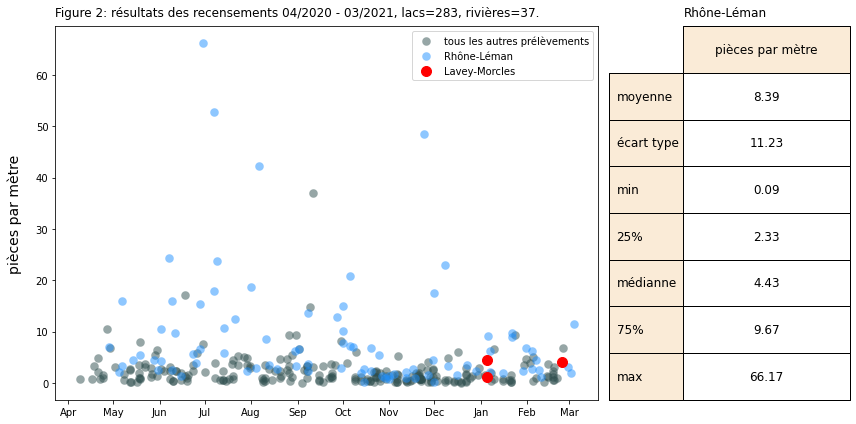

In [16]:
# adjust table kwargs
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), cellLoc='center')

fig = plt.figure(constrained_layout = False, figsize=(12,6))
figure_num += 1

# declare a grid
gs = GridSpec(1, 7, figure=fig)

# put an ax on it
ax1 = fig.add_subplot(gs[5:])

# the context matters for the row and column labels
if is_french:
    rowLabels = summary_row_fr
    col_label = [french_pcm]
else:
    col_label = ['pieces per meter']

# define the table
a_table = mpl.table.table(
    cellText=bassin_table,
    rowLabels=rowLabels,
    rowColours=['antiquewhite' for i in rowLabels],
    colLabels=col_label,
    colColours=['antiquewhite' for col in np.arange(1)],
    
    ax=ax1,
    **tablecenter_k)

def table_format(a_table, ax, size=12):
    table_fonts(a_table, size=size)
    make_table_grids(ax)
    ax.tick_params(**tabtickp_k)

table_format(a_table, ax1) 

# add table to ax
ax1.add_table(a_table )

# scatter plot
ax2 = fig.add_subplot(gs[0:5])
sns.scatterplot(data=allsurveys[~allsurveys.location.isin(bassin_locs)], x='date',  y='pcs_m', alpha=0.5, label="tous les autres prélèvements", color='darkslategray', edgecolor='darkslategray', linewidth=.1,s=70,ax=ax2)
sns.scatterplot(data=allsurveys[allsurveys.location.isin(bassin_locs)], x='date',  y='pcs_m', alpha=0.5, label=bassin_label, color='dodgerblue', edgecolor='dodgerblue', linewidth=.1,s=70,ax=ax2)
sns.scatterplot(data=lavey, x='date',  y='pcs_m', alpha=1, label=coi, color='red', edgecolor='red', linewidth=1,s=100, ax=ax2)
# format scatter
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(allmonths)
ax2.set_xlabel("")

# context
if is_french:
    ax1.set_title(F"{bassin_label}", loc='left', pad=10)
    ax2.set_title(F"Figure {figure_num}: {french_srs} {startyearmonth} - {endyearmonth}, lacs={lakecount}, rivières={rivercount}.", loc='left', pad=10)
    ax2.set_ylabel(F"{french_pcm}", **ylab_k)
else:
    ax1.set_title(F"{bassin_label}", loc='left', pad=10)
    ax2.set_ylabel("Pieces per meter", **ylab_k)
    ax2.set_title(F"Figure {figure_num}: survey totals {startyearmonth} - {endyearmonth}, lakes={lakecount}, rivers={rivercount}", loc='left', pad=10)

plt.tight_layout()

# tag the output:
figname = F"figure{figure_num}.jpg"
atype = "figure"
tag =  'all surveys: scatter plot, key values table'
add_output(figname, tag, fignum=figure_num, atype=atype)

plt.show()
plt.close()

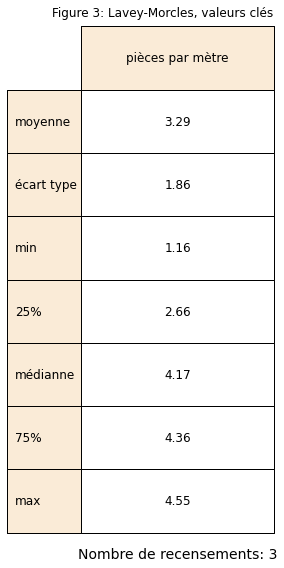

In [17]:
fig, ax1 = plt.subplots(figsize=(4,8))
figure_num += 1



# the context matters for the row and column labels
# count the number of samples for this summary
n_samples = F"Nombre de recensements: {lavey.loc_date.nunique()}"

if is_french:
    rowLabels = summary_row_fr
    col_label = [french_pcm]
    title = F"{coi}, valeurs clés"
else:
    col_label = ['pieces per meter']
    title = F"{coi}, key values"

# define the table
a_table = mpl.table.table(
    cellText=lavey_table,
    rowLabels=rowLabels,
    rowColours=['antiquewhite' for i in rowLabels],
    colLabels=col_label,
    colColours=['antiquewhite' for col in np.arange(1)],
    
    ax=ax1,
    **tablecenter_k)

def table_format(a_table, ax, size=12):
    table_fonts(a_table, size=size)
    make_table_grids(ax)
    ax.tick_params(**tabtickp_k)

table_format(a_table, ax1)
ax1.set_title(F"Figure {figure_num}: {title}", pad=10, ha='right', loc='right')
ax1.set_xlabel(n_samples, **ylab_k)

# add table to ax
ax1.add_table(a_table)
plt.tight_layout()

# tag the output:
figname = F"figure{figure_num}.jpg"
atype = "figure"
tag =  F"key values {coi}"
add_output(figname, tag, fignum=figure_num, atype=atype)

plt.show()
plt.close()

In [18]:
if is_french:
    sommarkdown = """#### <span style="color:#008891"> Les objets les plus communs: toutes les enquêtes </span>\n    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Most common objects: all surveys</span>\n    
     """

In [19]:
display(Markdown(sommarkdown))

#### <span style="color:#008891"> Les objets les plus communs: toutes les enquêtes </span>
    
    

In [20]:
# get the total quantity and pieces per meter for each code
# code quantity:
allcodevals = pd.DataFrame(newdfx.groupby('code').quantity.sum())
bassincodevals = pd.DataFrame(newdfx[newdfx.location.isin(bassin_locs)].groupby('code').quantity.sum())
lavey_codevals = pd.DataFrame(newdfx[(newdfx.location.isin(lavey_locs))].groupby('code').quantity.sum())

# code median pcs/m
bassin_pcsm = newdfx[(newdfx.location.isin(bassin_locs))].groupby('code').pcs_m.median()
lavey_pcsm = newdfx[(newdfx.location.isin(lavey_locs))].groupby('code').pcs_m.median()
all_pcsm = newdfx.groupby('code').pcs_m.median()

# make a df of all codes for each regional level add description, material, group and percent of regional total:
for a_df in [allcodevals, lavey_codevals, bassincodevals]:
    # add description and material from the codes df
    a_df['description'] = a_df.index.map(lambda x: dfCodes.loc[x].description)
    a_df['material'] = a_df.index.map(lambda x: dfCodes.loc[x].material)
    a_df['group'] = a_df.index.map(lambda x: a_group_map[x])
    a_total = a_df.quantity.sum()
    a_df['p_total'] = a_df.quantity/a_total
    a_df['p_total'] = a_df['p_total'].round(2)
    a_df.sort_values(by='quantity',ascending=False)
    a_df.rename(columns={'p_total':'% of total'}, inplace=True)

# make a top ten table for each region:
lavey_tabledata = lavey_codevals[lavey_codevals.quantity > 0][['description', 'material', 'quantity', '% of total', 'group']].copy()
top_ten_lavey = lavey_tabledata.sort_values(by='quantity', ascending=False).iloc[:10].copy()
top_ten_lavey['pcs_m'] = top_ten_lavey.index.map(lambda x: lavey_pcsm.loc[x])
top_ten_lavey_table = top_ten_lavey[['description', 'material', 'quantity','% of total',  'pcs_m', 'group']].copy()
top_ten_lavey_table.reset_index(inplace=True)

bassin_tabledata = bassincodevals[bassincodevals.quantity > 0][['description', 'material', 'quantity', '% of total', 'group']].copy()
top_ten_bassin = bassin_tabledata.sort_values(by='quantity', ascending=False).iloc[:10].copy()
top_ten_bassin['pcs_m'] = top_ten_bassin.index.map(lambda x: bassin_pcsm.loc[x])
top_ten_bassin_table = top_ten_bassin[['description', 'material', 'quantity','% of total',  'pcs_m', 'group']].copy()
top_ten_bassin_table.reset_index(inplace=True)

all_tabledata = allcodevals[allcodevals.quantity > 0][['description', 'material', 'quantity', '% of total', 'group']].copy()
top_ten_all = all_tabledata.sort_values(by='quantity', ascending=False).iloc[:10].copy()
top_ten_all['pcs_m'] = top_ten_all.index.map(lambda x: all_pcsm.loc[x])
top_ten_all_table = top_ten_all[['description', 'material', 'quantity','% of total',  'pcs_m', 'group']].copy()
top_ten_all_table.reset_index(inplace=True)

In [21]:
# get the group total and percentage of total for each code group and level:
lavey_groups = useThis[(useThis.location.isin(lavey_locs))].groupby('groupname', as_index=False).quantity.sum()
lavey_group_pcsm = useThis[(useThis.location.isin(lavey_locs))].groupby(['groupname','loc_date', 'date', 'location'], as_index='groupname').pcs_m.sum()
lavey_group_pcsm = lavey_group_pcsm.groupby('groupname').median()
atotal = lavey_groups.quantity.sum()
lavey_groups['p_total'] = (lavey_groups.quantity/atotal)*100
lavey_groups['p_total'] = lavey_groups['p_total'].round(2)
lavey_groups.sort_values(by='p_total', ascending=True, inplace=True)
anorder = lavey_groups.groupname.values

bassin_groups = useThis[(useThis.location.isin(bassin_locs))].groupby('groupname', as_index=False).quantity.sum()
atotal = bassin_groups.quantity.sum()
bassin_groups['p_total'] = (bassin_groups.quantity/atotal)*100
bassin_groups['p_total'] = bassin_groups['p_total'].round(2)
bassin_groups.sort_values(by='p_total', ascending=True, inplace=True)

all_groups = useThis[(useThis.location.isin(lavey_locs))].groupby('groupname', as_index=False).quantity.sum()
atotal = all_groups.quantity.sum()
all_groups['p_total'] = (all_groups.quantity/atotal)*100
all_groups['p_total'] = all_groups['p_total'].round(2)
all_groups.sort_values(by='p_total', ascending=True, inplace=True)

In [22]:
boxes = useThis.groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()
boxes_l = useThis[useThis.location.isin(lavey_locs)].groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()
boxes_b = useThis[useThis.location.isin(bassin_locs)].groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()

get_an_order_l = boxes_l.groupby('groupname').pcs_m.median()
an_order_of_boxes_l = get_an_order_l.sort_values(ascending=True)
a_box_order_l = an_order_of_boxes_l.index


In [23]:
# get the significant value for each code group
sig_vals = boxes.groupby('groupname').pcs_m.quantile(sig)
sig_vals_b = boxes_b.groupby('groupname').pcs_m.quantile(sig)
# get the significant value for each code
# sig_vals_code = useThis.groupby('code').pcs_m.median()
# sig_vals_bassin  = useThis[useThis.location.isin(bassin_locs)].groupby('code').pcs_m.median()
# bassin_pcsm = newdfx[(newdfx.location.isin(bassin_locs))].groupby('code').pcs_m.median()


# map the significant value to the results
boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# create a boolean for significant
boxes['significant'] = boxes.pcs_m >= boxes.limit

# map to number of samples, and significant values
survey_totals = useThis.groupby(['loc_date','location','water_name', 'date','population'], as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})
survey_totals.reset_index(inplace=True)

# number of samples per lake
tries = survey_totals.groupby(['water_name']).loc_date.nunique()

# number of locations per lake
num_locations = survey_totals.groupby('water_name').location.nunique()

# fails: number of locations where object group has been identified
num_with = useThis[useThis.quantity > 0].groupby(['water_name', 'groupname']).location.nunique()

# fails: number of samples with the object group
samps_with = useThis[useThis.quantity > 0].groupby(['water_name', 'groupname']).loc_date.nunique()

# median pcs_m
median_pcs = boxes.groupby(['water_name', 'groupname']).pcs_m.median()

# mean pcs_m
mean_pcs = boxes.groupby(['water_name', 'groupname']).pcs_m.mean()

# significant values
# determine wether or not the event was greater than the 90th percentile

# map limit to data
boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# create boolean
boxes['significant'] = boxes.pcs_m >= boxes.limit

# make a df of tests and test failures
fails = boxes.groupby(['water_name', 'groupname'], as_index=False).significant.sum()

# get the number of samples for the lake
fails['samples'] = fails.water_name.map(lambda x: tries[x])

# display the ratio of significant values to samples
fails['frequency_s'] = fails.significant.astype('str') + '/' + fails.samples.astype('str')

# the number of locations
fails['locations'] = fails.water_name.map(lambda x: num_locations[x])

def locations_with(x,y,somdata):
    try:
        has = somdata[x][y]        
    except:
        has = 0
    return has
        
# the number of locations where the object group has been identified
fails['loc_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], num_with), axis=1)

# the number of samples where the object group has been identified
fails['samp_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], samps_with), axis=1)

# samples frequency of failure
fails['frequency'] = fails.samp_with.astype('str') + '/' + fails.samples.astype('str')

# locations frequency of failure
fails['frequency_l'] = fails.loc_with.astype('str') + '/' + fails.locations.astype('str')

# median/mean pcs_m:
fails['median pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], median_pcs), axis=1)
fails['mean pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], mean_pcs), axis=1)

# likelihood
fails['likelihood'] = ((fails.loc_with/fails.locations)*(fails.samp_with/(fails.samples+1)))

def make_minimum_likelihood(x,samples=100):
    # even if an item has never been found
    # it is assumed that there is always a chance
    # that it may be found. That chance is equal
    # 1/n samples * 1/n location (found at one sample and one location)
    if x == 0 :
            min_val = (1/samples)
    else:
        min_val = x
    return min_val


fails['likelihood'] = fails.apply(lambda x:make_minimum_likelihood(x['likelihood']), axis=1)

table_data = fails[['water_name','frequency_l', 'frequency',  'frequency_s', 'likelihood','median pcs/m', 'groupname']].copy()
table_data.rename(columns={'water_name':'name', 'frequency_l':"# locations", 'frequency':"# samples", 'frequency_s':'# significant'}, inplace=True)

national_median = boxes.groupby('groupname').pcs_m.median()

this_data = pd.DataFrame(boxes_l.groupby('groupname').pcs_m.median())
this_data['catchment area'] = this_data.index.map(lambda x:lavey_group_pcsm[x] )
if is_french:
    this_data.rename(columns={'catchment area':'bassin versant', 'pcs_m':'résultats locaux'}, inplace=True)
    this_data['groupname'] = this_data.index.map(french_names)
    this_data.set_index('groupname', inplace=True)

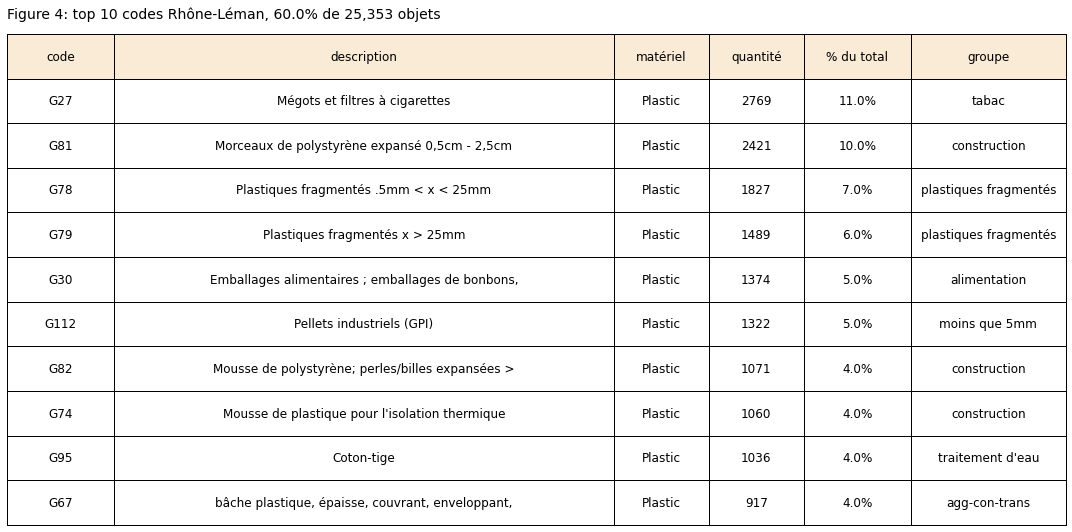

In [24]:

# sum the % of total of the most common objects
ptotal = top_ten_bassin_table['% of total'].sum()*100
psum = top_ten_bassin_table.quantity.sum()
toptenqty = bassincodevals.quantity.sum()

# context print tables
top_ten_table_p = top_ten_bassin_table.copy()
top_ten_table_p['% of total'] = top_ten_table_p['% of total']*100
top_ten_table_p['% of total'] = top_ten_table_p['% of total'].round(1).astype('str')
top_ten_table_p['% of total'] = top_ten_table_p['% of total'] + "%"
# context is_french 
if is_french:
    bassin_tabledatacopy = top_ten_table_p.copy()
    bassin_tabledatacopy.reset_index(inplace=True)
    bassin_tabledatacopy['description'] = bassin_tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    bassin_tabledatacopy['group'] = bassin_tabledatacopy.group.map(lambda x: count_k(french_names[x], limit))
    bassin_tabledatacopy.rename(columns=french_columns, inplace=True)
    thetabledata = bassin_tabledatacopy[['code','description', 'matériel', 'quantité', '% du total','groupe']].copy()
else:
    the_top_ten_table = top_ten_table_p[['code','description', 'material', 'quantity', '% of total','group']].copy()
    the_top_ten_table.reset_index=(True)
    thetabledata = the_top_ten_table.copy()
    

# make adjustments to table kwargs:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[9, 42, 8, 8, 9,13], cellLoc='center')

# plot the table:
fig, ax = plt.subplots(figsize=(15, len(thetabledata)*.75))
figure_num += 1
ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=thetabledata.values,
    colLabels=thetabledata.columns,
    colColours=['antiquewhite' for col in list(thetabledata.columns)],    
    ax=ax,
    **tablecenter_k)

# set parameters
table_fonts(a_table, size=12)
ax.tick_params(**tabtickp_k)

# add the table
ax.add_table(a_table)


if is_french:
    ax.set_title(F"Figure {figure_num}: top {len(thetabledata)} codes {bassin_label}, {np.round(ptotal, 2)}% de {'{:,}'.format(toptenqty)} objets", **title_k14)
else:
    ax.set_title(F"Figure {figure_num}: top {len(thetabledata)} codes {bassin_label}, {np.round(ptotal, 2)}% of {'{:,}'.format(toptenqty)} objects", **title_k14)


plt.tight_layout()
figname = F"figure{figure_num}.jpg"
tag = F'{bassin_label}: 10 most common objects table'
add_output(figname, tag, fignum=figure_num)
plt.show()
plt.close()

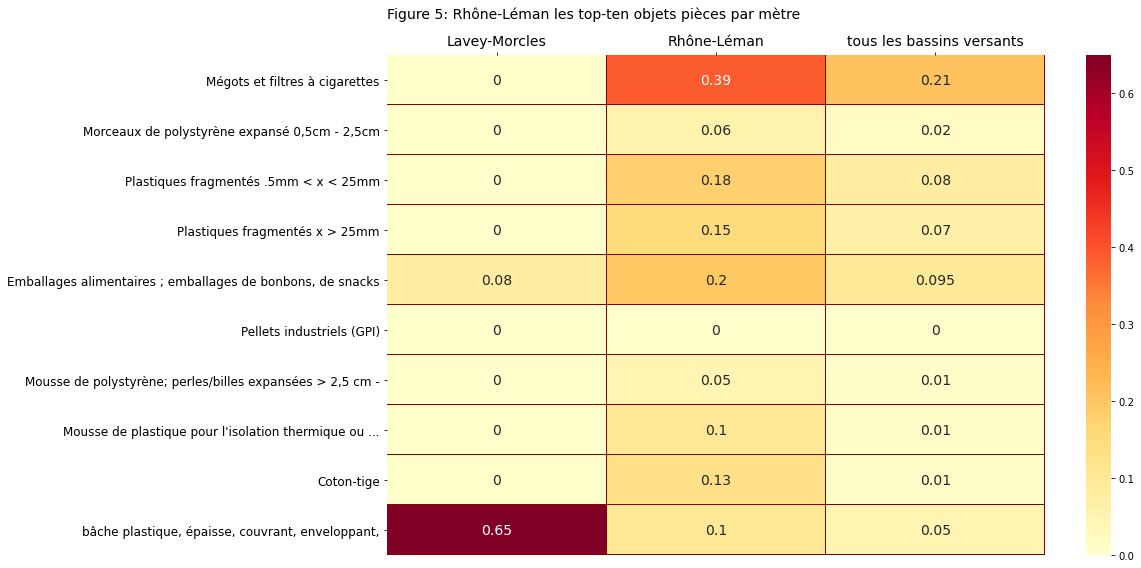

In [25]:
# make a table of results that compares the pcs/m for the national top ten codes accross the regional levels

top_ten_bassin_table[coi] = top_ten_bassin_table.code.map(lambda x: lavey_pcsm[x])
top_ten_bassin_table['tous les bassins versants'] = top_ten_bassin_table.code.map(lambda x: all_pcsm[x])
top_ten_bassin_table.set_index('code', inplace=True)


top_ten_tablex = top_ten_bassin_table.rename(columns={'pcs_m':bassin_label})
top_ten_tablex['description'] = top_ten_bassin_table.index.map(lambda x: fr_defs_codes[x])
top_ten_tablex = top_ten_tablex[[coi, bassin_label,'tous les bassins versants', 'description']].copy()

top_ten_tablex.set_index('description', inplace=True)
top_ten_tablex.columns = [coi, bassin_label, 'tous les bassins versants']

fig, ax = plt.subplots(figsize=(17,8))
figure_num += 1
title=F"Figure {figure_num}: {bassin_label} les top-ten objets pièces par mètre"
sns.heatmap(data=top_ten_tablex, cmap='YlOrRd', linewidth=0.1, linecolor='darkred', annot=True, ax=ax, annot_kws={"fontsize":14})
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=12, rotation=0)
ax.set_title(title, **title_k14)

plt.tight_layout()
figname = F"figure{figure_num}.jpg"
tag = 'top-ten regional-local-national median'
add_output(figname, tag, fignum=figure_num)
plt.show()

plt.close()

In [26]:
# lavey_pcsm
# lavey_pcsm['hmm'] = lavey_pcsm.index.map(lambda x: bassin_pcsm[x])
exceeds_catchment_median = [x for x in lavey_pcsm.index if lavey_pcsm[x] > bassin_pcsm[x]]
exceeds_catchment_median = [x for x in exceeds_catchment_median if x not in top_ten_bassin_table.index]
codes_of_interest = bassin_tabledata.loc[bassin_tabledata.index.isin(exceeds_catchment_median)].copy()
codes_of_interest[coi] = codes_of_interest.index.map(lambda x: lavey_pcsm.loc[x])
codes_of_interest[bassin_label] = codes_of_interest.index.map(lambda x: bassin_pcsm.loc[x])
# top_ten_tablex = codes_of_interest.rename(columns={'pcs_m':bassin_label})
codes_of_interest['description'] = codes_of_interest.index.map(lambda x: fr_defs_codes[x])
codes_of_interest = codes_of_interest[[coi, bassin_label, 'description']].copy()
codes_of_interest.sort_values(by=coi, ascending=False, inplace=True)
codes_of_interest.set_index('description', inplace=True)

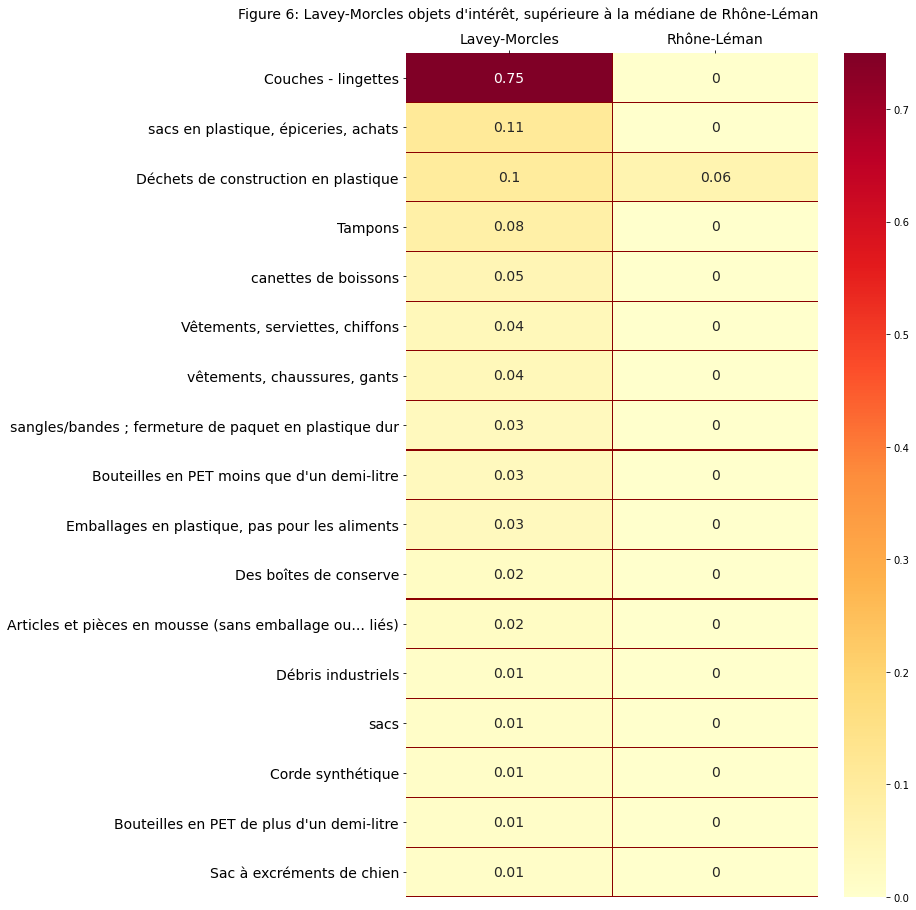

In [27]:

codes_of_interest.columns = [coi, bassin_label]

fig, ax = plt.subplots(figsize=(13,len(codes_of_interest)*.75))
figure_num += 1
title=F"Figure {figure_num}: {coi} objets d'intérêt, supérieure à la médiane de {bassin_label}"
sns.heatmap(data=codes_of_interest, cmap='YlOrRd', linewidth=0.1, linecolor='darkred', annot=True, ax=ax, annot_kws={"fontsize":14})
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=14, rotation=0)
ax.set_title(title, ha='right', loc='right', fontsize=14, pad=14)

plt.tight_layout()
figname = F"figure{figure_num}.jpg"
tag = 'objects of interest'
add_output(figname, tag, fignum=figure_num)
plt.show()

plt.close()

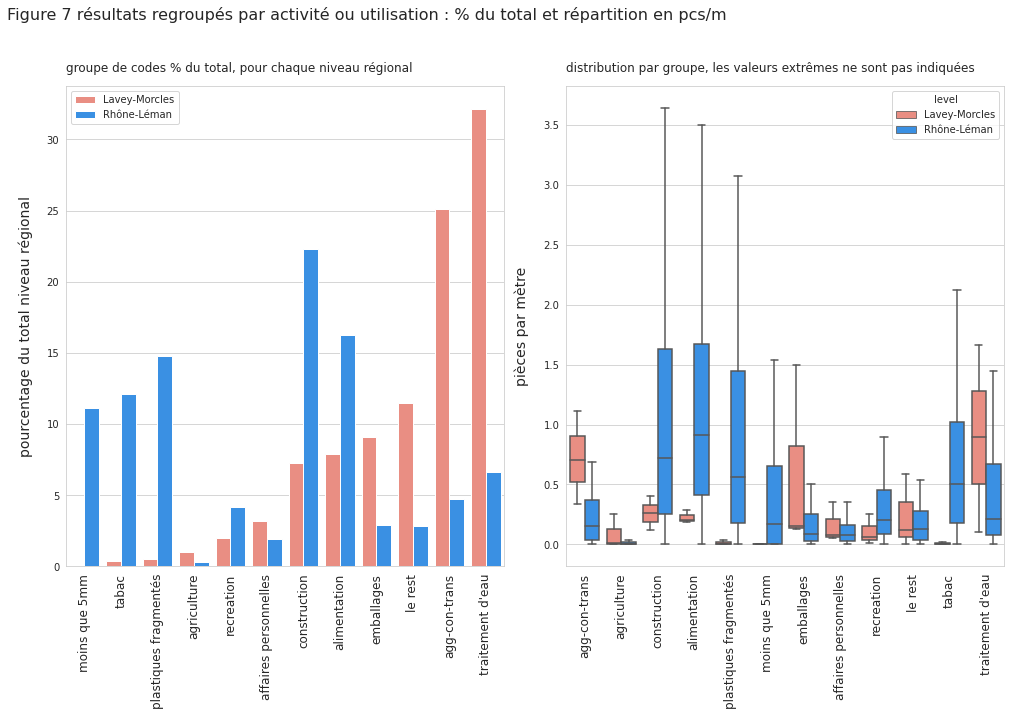

In [28]:
sns.set_style('whitegrid')

# assign a regionallevel to the codegroup results


boxes_b['level'] = boxes_b.location.map(lambda x: assign_a_level(x, lavey_locs, [coi, bassin_label]))

# assign a regional level to each set of data
bassin_groups['level'] = bassin_label
lavey_groups['level'] = coi

# merge the data sets
these_groups = lavey_groups.append(bassin_groups)

a_form = mtick.FormatStrFormatter('%.0f%%')

fig, ax = plt.subplots(1,2, figsize=(14, 10))
an_order = [coi, bassin_label]
figure_num += 1
if is_french:
    these_groups['groupname'] = these_groups['groupname'].map(lambda x: french_names[x])
    boxes_b['groupname'] = boxes_b['groupname'].map(lambda x: french_names[x])
#     anorder = [french_names[x] for x in a_box_order_l]
#     this_data.rename(columns={'catchment area':'bassin versant', 'pcs_m':'résultats locaux'}, inplace=True)
#     this_data['groupname'] = this_data.index.map(french_names)
#     this_data.set_index('groupname', inplace=True)

    sns.barplot(data=these_groups, x='groupname', hue='level', hue_order=an_order, palette={coi:'salmon', bassin_label:'dodgerblue'}, y='p_total', ax=ax[0])
    ax[0].set_ylabel(F"{french_pct} niveau régional", **ylab_k)
    ax[0].set_title(F"groupe de codes % du total, pour chaque niveau régional", **title_k)
    ax[0].set_xlabel("")
    ax[0].tick_params(axis='x', which='both',labelsize=12, rotation=90)
    ax[0].legend(loc='upper left')    
    
    sns.boxplot(data=boxes_b[['groupname','pcs_m', 'level']], x='groupname', y='pcs_m', hue='level',  hue_order=an_order, palette={coi:'salmon', bassin_label:'dodgerblue'}, ax=ax[1],  showfliers=False)
    ax[1].set_ylabel(F"{french_pcm}", **ylab_k)
    ax[1].set_title(F"distribution {french_bg}, {french_nooutliers}", **title_k)
    ax[1].set_xlabel("")
    ax[1].tick_params(axis='x', which='both',labelsize=12, rotation=90)

else:
    sns.barplot(data=these_groups, x='groupname', hue='level', palette=['red', 'blue'], y='p_total', dodge=False, ax=ax[0])
    ax[0].set_ylabel("Percent total of all objects at regaional level", **ylab_k)
    ax[0].set_title(F"code group % of total, for each regional level", **title_k)
    ax[0].yaxis.set_major_formatter(a_form)
    ax[0].set_xlabel("")
    ax[0].tick_params(axis='x', which='both',labelsize=12, rotation=90)
    ax[0].legend(loc='upper left')    
    
    sns.boxplot(data=boxes_l[['groupname','pcs_m']], x='groupname', y='pcs_m', hue='groupname', palette=grouppalette, order=a_box_order_l, dodge=False, ax=ax[1], showfliers=False)
    ax[1].set_ylabel("Pieces per meter", labelpad=10, **ylab_k)
    ax[1].set_title(F"disribution of groups, outliers not shown", **title_k)
    ax[1].set_xlabel("")
    ax[1].tick_params(axis='x', which='both',labelsize=12, rotation=90)
    
    
    
fignum=figure_num

if is_french:
    suptitle =F"Figure {figure_num} résultats regroupés par activité ou utilisation : % du total et répartition en pcs/m"
else:
    suptitle = F"Figure {figure_num} results grouped by activity or use: % of total and distribution in pcs/m"

plt.suptitle(suptitle, x=0, y=.99, ha='left', fontsize=16, linespacing=2)

    
plt.tight_layout()
plt.subplots_adjust(top=.88)
figname = F"figure{fignum}.jpg"
atype='figure'
tag = 'code groups: percentage of total, distribution, regional results'
add_output(figname, tag, fignum=fignum, atype=atype)
plt.show()
plt.close()

In [29]:
a = boxes_b.groupby(['level', 'groupname'], as_index=False).pcs_m.median()
a=a.pivot(columns='level', index='groupname')
a.columns = a.columns.get_level_values(1)

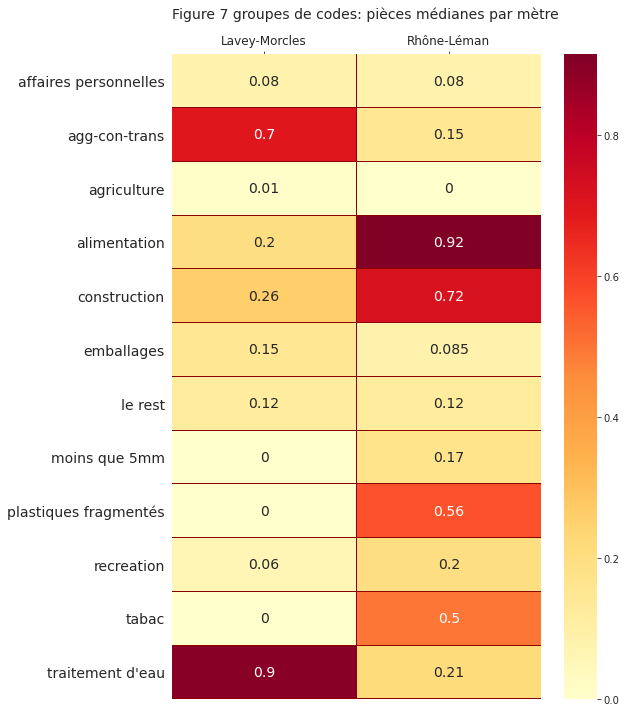

In [30]:


fig, ax = plt.subplots(figsize=(9,10))
if is_french:
    title = F"Figure {figure_num} groupes de codes: pièces médianes par mètre"
    
else:
    title = "Local median compared to catchment area"
    
sns.heatmap(data=a, cmap='YlOrRd', linewidth=0.1, linecolor='darkred', annot=True, annot_kws={"fontsize":14}, ax=ax)
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=12)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=14, rotation=0)
ax.set_title(title, **title_k14)
plt.tight_layout()
figname = F"figure{figure_num}.jpg"
atype='figure'
tag = F"code groups: {coi} and {bassin_label} median pcs/m"
add_output(figname, tag, fignum=figure_num, atype=atype)
plt.show()
plt.close()


6


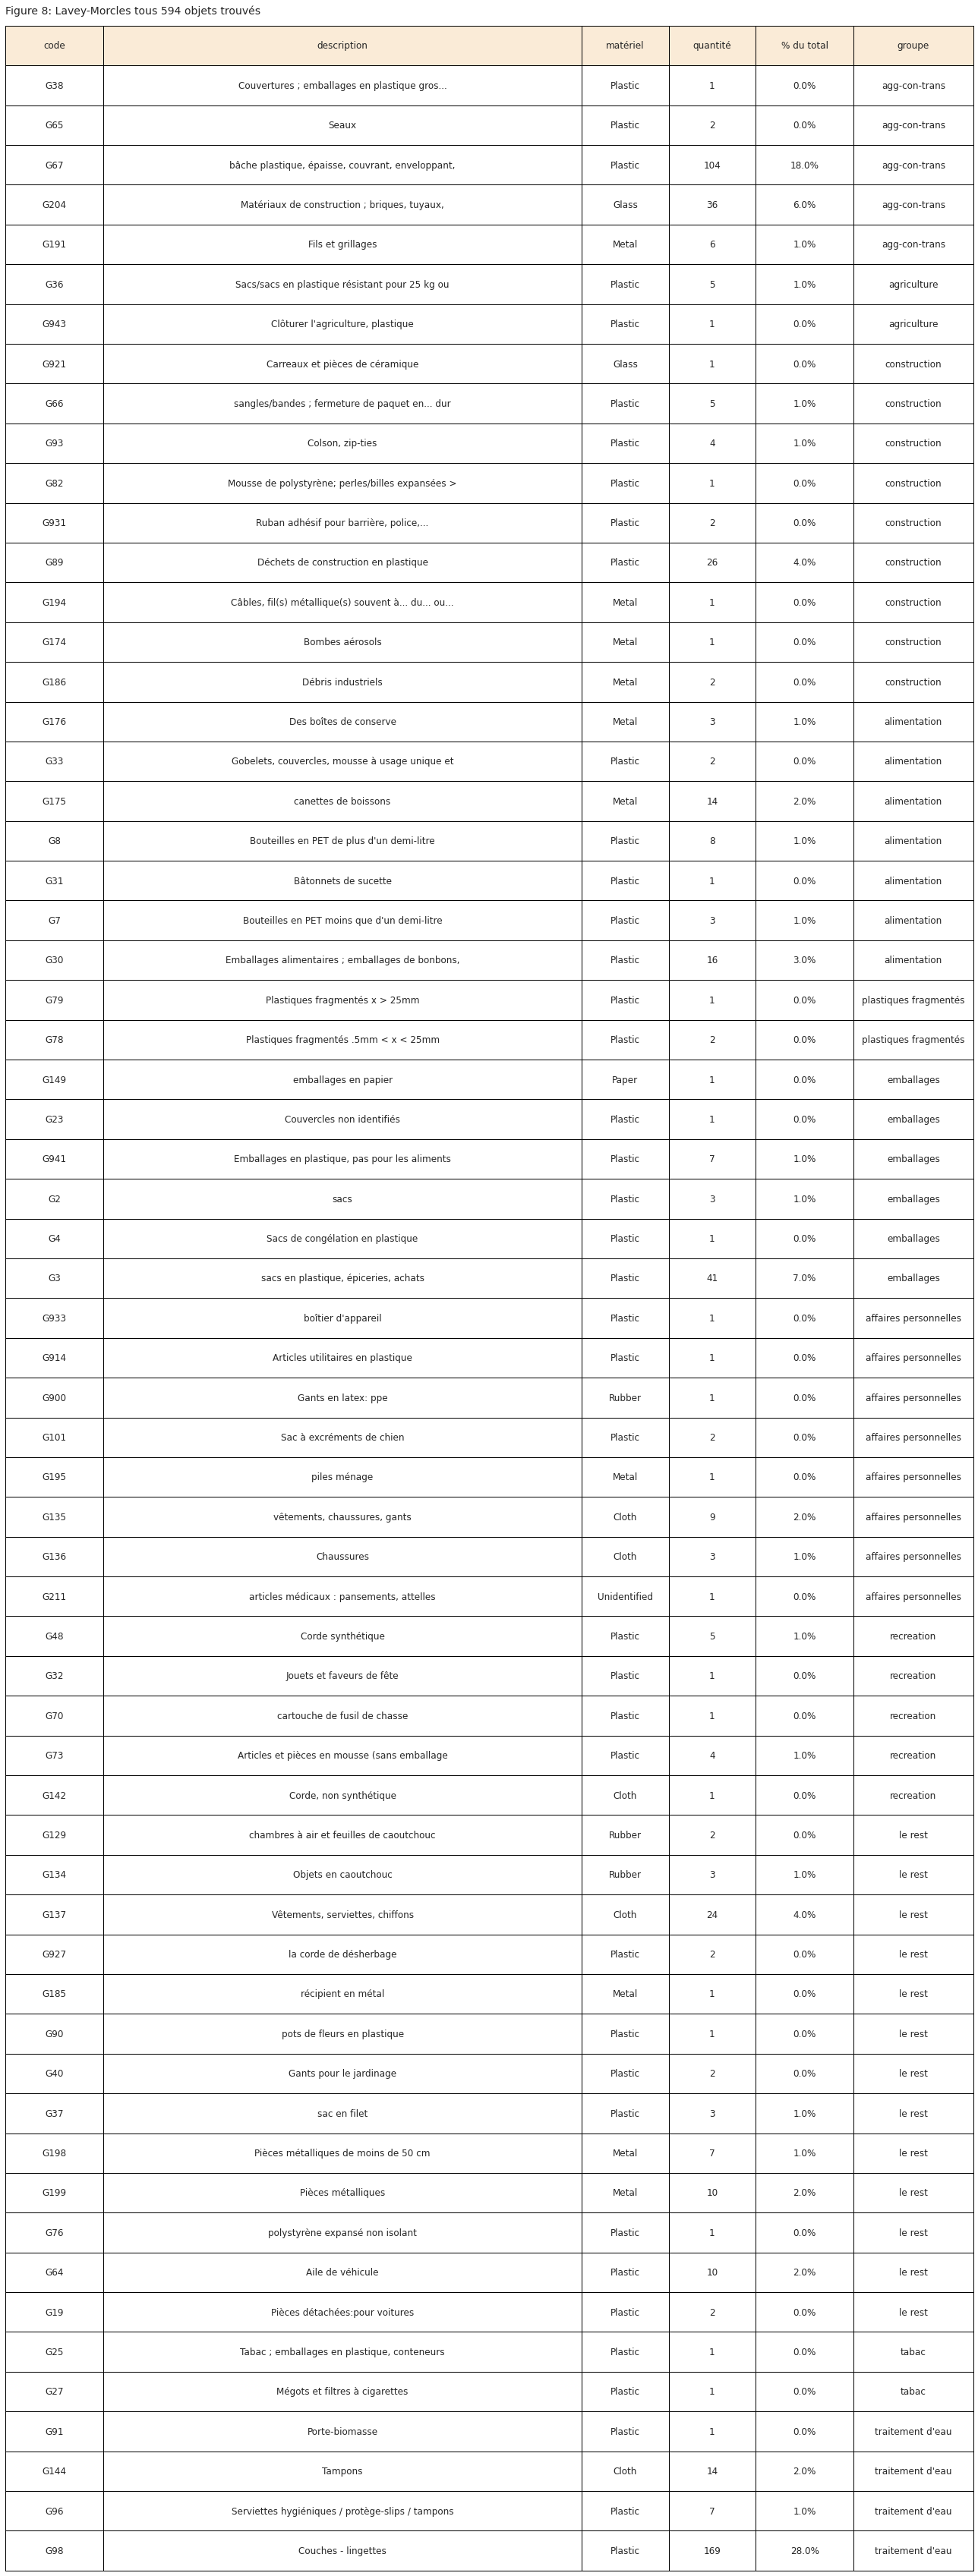

In [31]:
this_tabledata = lavey_tabledata.reset_index()

# context print tables
this_tabledata_p = lavey_tabledata.copy()
a_total = this_tabledata.quantity.sum()
this_tabledata_p['% of total'] = this_tabledata_p['% of total']*100
this_tabledata_p['% of total'] = this_tabledata_p['% of total'].round(1).astype('str')
this_tabledata_p['% of total'] = this_tabledata_p['% of total'] + "%"
# context is_french 
if is_french:
    tabledatacopy = this_tabledata_p.copy()
    tabledatacopy.reset_index(inplace=True)
    tabledatacopy.sort_values(by='group', inplace=True)
    tabledatacopy['description'] = tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    tabledatacopy['group'] = tabledatacopy.group.map(lambda x: count_k(french_names[x], limit))
    tabledatacopy.rename(columns=french_columns, inplace=True)
    thetabledata = tabledatacopy[['code','description', 'matériel', 'quantité', '% du total','groupe']].copy()
    this_tabledata = thetabledata 
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[9, 44, 8, 8, 9,11], cellLoc='center')
# this_tabledata = this_tabledata[this_tabledata.code.isin([x for x in this_tabledata.code.unique() if x not in fr_defs_codes.keys()] )]
# plot the table:
print(len(this_tabledata.columns))
fig, ax = plt.subplots(figsize=(18, len(this_tabledata)*.75))
figure_num += 1
ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=this_tabledata.values,
    colLabels=this_tabledata.columns,
    colColours=['antiquewhite' for col in list(this_tabledata.columns)],    
    ax=ax,
    **tablecenter_k)

# set parameters
table_fonts(a_table, size=12)
ax.tick_params(**tabtickp_k)

# add the table
ax.add_table(a_table)


if is_french:
    ax.set_title(F"Figure {figure_num}: {coi} tous {a_total} objets trouvés", **title_k14)
else:
    ax.set_title(F"Figure {figure_num}: {coi} all objects found", **title_k14)


plt.tight_layout()
figname = F"figure{figure_num}.jpg"
tag = F"{coi}: all objects table"
add_output(figname, tag, fignum=figure_num)
plt.show()
plt.close()

In [32]:
# map number of sample per locations
tries_l = boxes.groupby('location').loc_date.nunique()

# map number of times at least one item was found
fails_l = boxes[boxes.pcs_m > 0].groupby(['location', 'groupname']).loc_date.nunique()
# lake_l = fails.set_index(['groupname','water_name'], inplace = True)
fails

,water_name,groupname,significant,samples,frequency_s,locations,loc_with,samp_with,frequency,frequency_l,median pcs/m,mean pcs/m,likelihood
0,Aare,agg-con-trans,0,11,0/11,11,3,3,3/11,3/11,0.00,0.017273,0.068182
1,Aare,agriculture,0,11,0/11,11,0,0,0/11,0/11,0.00,0.000000,0.010000
2,Aare,construction,0,11,0/11,11,5,5,5/11,5/11,0.00,0.046364,0.189394
3,Aare,food,0,11,0/11,11,9,9,9/11,9/11,0.08,0.128182,0.613636
4,Aare,fragmented plastics,0,11,0/11,11,5,5,5/11,5/11,0.00,0.067273,0.189394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Zurichsee,personal items,5,51,5/51,10,8,36,36/51,8/10,0.05,0.130196,0.553846
272,Zurichsee,recreation,3,51,3/51,10,10,44,44/51,10/10,0.07,0.181373,0.846154
273,Zurichsee,the rest,6,51,6/51,10,10,45,45/51,10/10,0.10,0.154118,0.865385
274,Zurichsee,tobacco,5,51,5/51,10,10,50,50/51,10/10,0.54,0.763922,0.961538


In [33]:
tries_l

location
aabach                                       1
aare-limmatspitz                             1
aare-solothurn-lido-strand                   1
aare_bern_gerberm                            1
aare_bern_scheurerk                          1
                                            ..
zuerichsee_waedenswil_colomboc_1             1
zugerseecholler_cham_blarerm                 1
zurcher-strand                               2
zurichsee_kusnachterhorn_thirkell-whitej    11
zurichsee_wollishofen_langendorfm           11
Name: loc_date, Length: 114, dtype: int64

In [34]:
fails_l

location                           groupname          
aabach                             agg-con-trans           1
                                   construction            1
                                   food                    1
                                   fragmented plastics     1
                                   less than 5mm           1
                                                          ..
zurichsee_wollishofen_langendorfm  personal items         10
                                   recreation              9
                                   the rest               11
                                   tobacco                11
                                   waste water             4
Name: loc_date, Length: 989, dtype: int64

In [35]:

fails_beach = boxes.groupby(['location', 'water_name','groupname'], as_index=False).pcs_m.median()
fails_beach

,location,water_name,groupname,pcs_m
0,aabach,Zurichsee,agg-con-trans,0.16
1,aabach,Zurichsee,agriculture,0.00
2,aabach,Zurichsee,construction,0.09
3,aabach,Zurichsee,food,0.13
4,aabach,Zurichsee,fragmented plastics,0.23
...,...,...,...,...
1363,zurichsee_wollishofen_langendorfm,Zurichsee,personal items,0.09
1364,zurichsee_wollishofen_langendorfm,Zurichsee,recreation,0.09
1365,zurichsee_wollishofen_langendorfm,Zurichsee,the rest,0.12
1366,zurichsee_wollishofen_langendorfm,Zurichsee,tobacco,0.56


In [36]:
# add a tries and fails column for each location and group
fails_beach['tries'] = fails_beach.location.map(lambda x: tries_l[x])
fails_beach['fails'] = fails_beach.apply(lambda x:locations_with(x['location'], x['groupname'], fails_l), axis=1)

# the ratio samples to failures
fails_beach['likelihood'] = (fails_beach.fails/fails_beach.tries)

# the r
# fails_beach['lakelikelihood'] = fails_beach.apply(lambda x:locations_with(x['groupname'], x['water_name'], lake_l), axis=1)
# fails_beach['likelihood'] = (fails_beach.loclikelihood*fails_beach.lakelikelihood)
# fails_beach

In [37]:
# get the fail rate per beach (how many times the quantity was greater than zero)

fails_beach_bassin  = fails_beach[fails_beach.water_name.isin(bassin)].groupby('groupname').agg({ 'tries':'sum', 'fails':'sum'})
fails_beach_bassin['group_rates'] = fails_beach_bassin.fails/ fails_beach_bassin.tries
print(fails_beach_bassin['tries'])
fails_beach_lavey = fails_beach[fails_beach.location.isin(lavey_locs)]
fails_beach_lavey.groupby(['groupname']  ).agg({'tries':'sum', 'fails':'sum'})

groupname
agg-con-trans          91
agriculture            91
construction           91
food                   91
fragmented plastics    91
less than 5mm          91
packaging              91
personal items         91
recreation             91
the rest               91
tobacco                91
waste water            91
Name: tries, dtype: int64


,tries,fails
groupname,,
agg-con-trans,3,3
agriculture,3,2
construction,3,3
food,3,3
fragmented plastics,3,1
less than 5mm,3,0
packaging,3,3
personal items,3,3
recreation,3,3


In [38]:
# account for the possibiliyt that there is always a chance of not finding anything
# def make_minimum_likelihood(x,samples=100, n=91):
#     # even if an item has never been found
#     # it is assumed that there is always a chance
#     # that it may be found. That chance is equal
#     # 1/n samples * 1/n location (found at one sample and one location)
#     if x == 0 :        
#         min_val = 1/n
#     else:
#         min_val = x
# #         min_val = round(min_val * 100,0)
# #         min_val = min_val
    
#     return min_val

# fails_beach['likelihood'] = fails_beach['likelihood'].map(lambda x: make_minimum_likelihood(x))
# fails_beach['likelihood'] = fails_beach['likelihood'].astype('int')
a = boxes.groupby('location').significant.sum()
these_beaches['significant'] = these_beaches.index.map(lambda x: a.loc[x])
these_beaches['median pcs/m'] = these_beaches.index.map(lambda x: allsurveys_pcs_median[x])
these_beaches.to_csv(F"{project_directory}/these_beaches.csv")
river_beaches = these_beaches[these_beaches.water == 'r']
river_beaches.to_csv(F"{project_directory}/these_rivers.csv")

In [39]:
fails_beach.columns

Index(['location', 'water_name', 'groupname', 'pcs_m', 'tries', 'fails',
       'likelihood'],
      dtype='object')

In [40]:
# get the fail rate per beach (how many times the quantity was greater than zero)


# fails_beach['loclikelihood'] = (fails_beach.fails/fails_beach.tries)
# fails_beach['lakelikelihood'] = fails_beach.apply(lambda x:locations_with(x['groupname'], x['water_name'], lake_l), axis=1)
# fails_beach['likelihood'] = (fails_beach.loclikelihood*fails_beach.lakelikelihood)

# account for the possibiliyt that there is always a chance of not finding anything
# def make_minimum_likelihood(x,samples=100):
#     # even if an item has never been found
#     # it is assumed that there is always a chance
#     # that it may be found. That chance is equal
#     # 1/n samples * 1/n location (found at one sample and one location)
#     if x == 0 :
        
#         min_val = (1/samples)
#     else:
#         min_val = x
# #     min_val = round(min_val * 100,1)
#     return min_val

# fails_beach['likelihood'] = fails_beach['likelihood'].map(lambda x: make_minimum_likelihood(x))
# fails_beach['likelihood'] = fails_beach['likelihood'].round(2)
a = boxes.groupby('location').significant.sum()
these_beaches['significant'] = these_beaches.index.map(lambda x: a.loc[x])
these_beaches['median pcs/m'] = these_beaches.index.map(lambda x: allsurveys_pcs_median[x])
these_beaches.to_csv(F"{project_directory}/these_beaches.csv")
river_beaches = these_beaches[these_beaches.water == 'r']
river_beaches.to_csv(F"{project_directory}/these_rivers.csv")

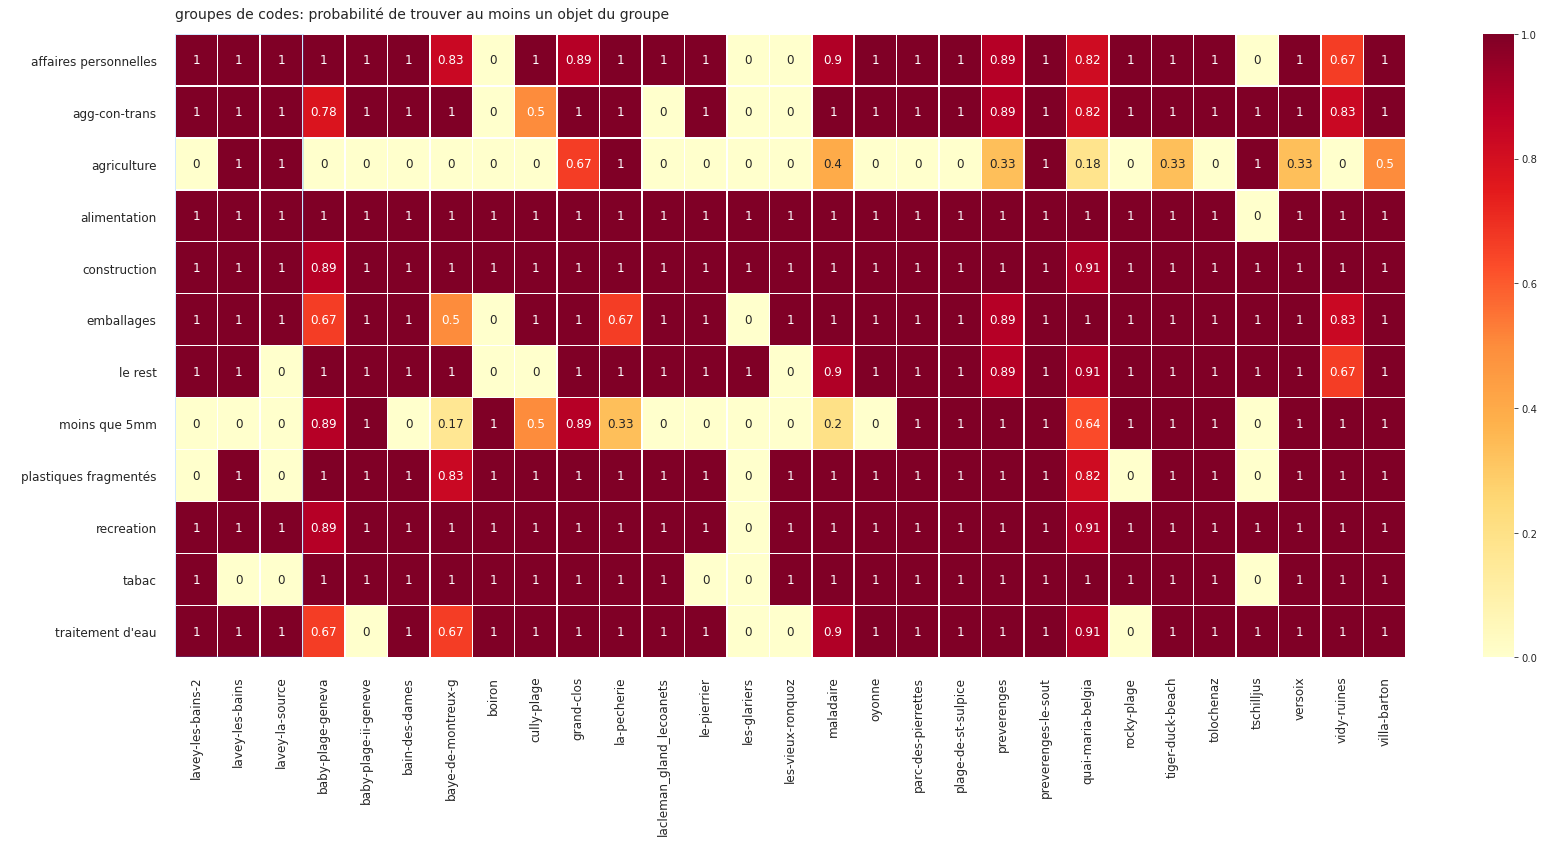

In [41]:
heat_map_palette = 'YlOrRd'
linecolor = 'white'
this_data = fails_beach[fails_beach.water_name.isin(bassin)].copy()
a = this_data[['location', 'groupname', 'likelihood']].copy()
if is_french:
    a['groupname'] = a.groupname.map(lambda x: french_names[x])
    title = "groupes de codes: probabilité de trouver au moins un objet du groupe"
else:
    title = "likelihood of finding at least one object from the group"
a = a.pivot(columns='location', index='groupname')
other_locs = [x for x in a.columns.get_level_values(1) if x not in lavey_locs]


# print(other_locs)
# print([*lavey_locs, *other_locs])
a = a.reindex([*lavey_locs, *other_locs], axis=1, level=1)

a_width = len(group_names)
a_height = len(this_data.water_name.unique())
fig,axx = plt.subplots(figsize=(24,12))
figure_num += 1

# this_data = fails_beach[(fails_beach.water_name == lake)|(fails_beach.water_name == 'Rhône')]
from matplotlib.patches import Rectangle
# axx.margins(x=1, y=1)
sns.heatmap(
    a, 
    cmap=heat_map_palette,
    linecolor=linecolor,
    ax=axx, 
    
    annot=True,
    annot_kws={'fontsize':12}, 
    linewidths=.5,
    
)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[len('likelihood')+1:]
    newlabels.append(newlabel)

axx.set_xticklabels(newlabels)

axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=12, pad=15)
# sns.despine(offset=2, trim=True);

axx.set_title(title, **title_k14)


axx.add_patch(Rectangle((0, 0), len(lavey_locs), len(a.index), fill=None, alpha=0.2, edgecolor='dodgerblue', lw=2))


plt.tight_layout()
atype="figure"
figname = F"figure{figure_num}.jpg"
tag = F"{lake} code groups percent of total by location."
add_output(figname,tag, fignum=figure_num, atype=atype)

plt.show()

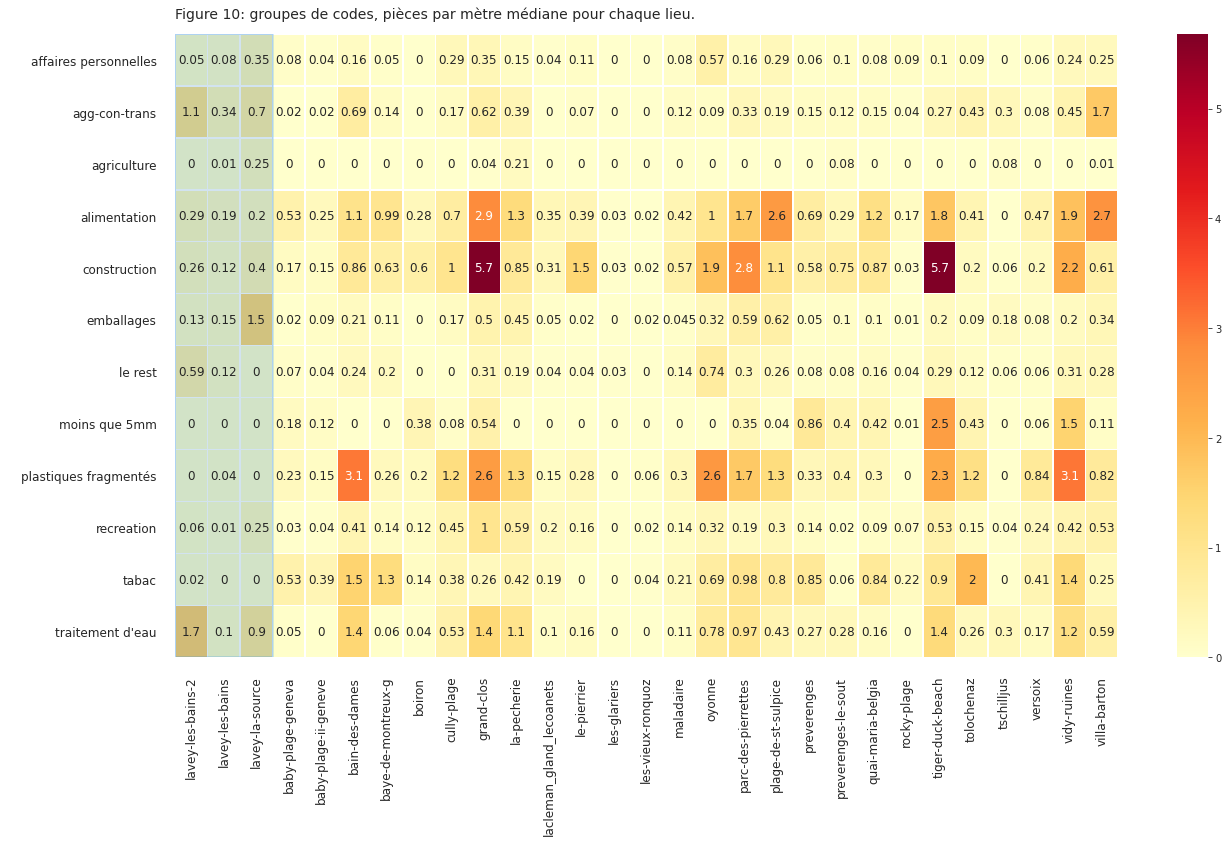

In [42]:
fig,axx = plt.subplots(figsize=(19,12))
figure_num += 1

a = this_data[['location', 'groupname',  'pcs_m']].copy()

# print(other_locs)
# print([*lavey_locs, *other_locs])

if is_french:
    a['groupname'] = a.groupname.map(lambda x: french_names[x])
    title = "groupes de codes, pièces par mètre médiane pour chaque lieu."
else:
    title = "code groups, median pieces per meter for each location."
a=a.pivot(columns='location', index='groupname')
other_locs = [x for x in a.columns.get_level_values(1) if x not in lavey_locs]
a = a.reindex([*lavey_locs, *other_locs], axis=1, level=1)
sns.heatmap(a,
            cmap=heat_map_palette, ax=axx, annot=True,annot_kws={'fontsize':12}, linewidths=.5, linecolor=linecolor)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[6:]
    newlabels.append(newlabel)
axx.set_xticklabels(newlabels, fontsize=12)
axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=12, pad=15)
axx.add_patch(Rectangle((0, 0), len(lavey_locs), len(a.index), fill='dodgerblue', alpha=0.2, edgecolor='dodgerblue', lw=2))

axx.set_title(F"Figure {figure_num}: {title}", **title_k14)

    
plt.tight_layout()
atype="figure"
figname = F"figure{figure_num}.jpg"
tag = F"{lake} all locations median pcs/m"
add_output(figname,tag, fignum=figure_num, atype=atype)
plt.show()

### Figures and data produced by this notebook:



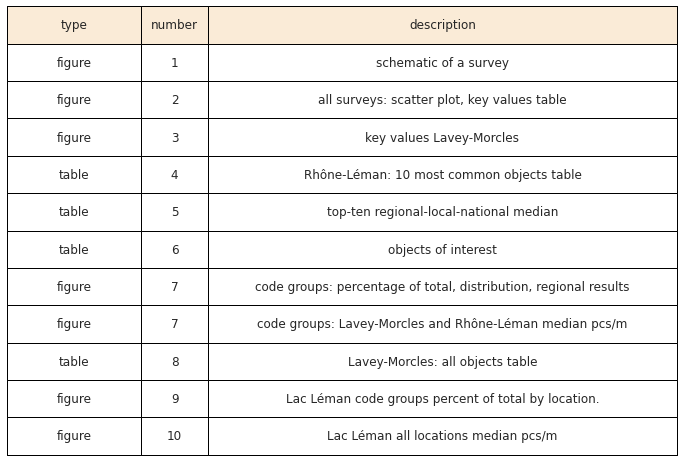

In [43]:
files_df = pd.DataFrame(files_generated[2:])
files_df.rename(columns={'tag':'description'}, inplace=True)

files_df = files_df[['type','number', 'description']]
files_df = files_df.sort_values(by='type')
files_df.sort_values(by='number', inplace=True)
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', colWidths=[20,10,70], fontsize=12)
tablecenter_kx = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)
        
with sns.axes_style('white', {'xtick.color':'white', 'ytick.color':'white'}):
    fig, axs = plt.subplots(figsize=(12,(len(files_df)*.75)), frameon=False)
    figure_num += 1
    sns.despine(fig=fig, top=True, left=True, right=True, bottom=True)

    make_table_grids(ax1)    

    a_table = axs.add_table(mpl.table.table(
        cellText=files_df.values,
        colLabels=files_df.columns,
        colColours=['antiquewhite' for col in files_df.columns],
        ax=axs,
        **tablecenter_k))


    table_fonts(a_table)

    axs.tick_params(**tabtickp_k)
    figname = F"figure{figure_num}.jpg"
    tag = F"{coi}: output table"
    add_output(figname, tag, fignum=figure_num)
    plt.show()
    plt.close()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch